In [152]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import cmocean.cm as ocm
import matplotlib
import matplotlib.gridspec as gridspec

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

tools_dir = os.path.join(src_dir,'tools')
sys.path.append(tools_dir)

from visualization.shiftedColorMap import shiftedColorMap
from log_progress import log_progress
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves

In [154]:
grd_path = os.path.join(data_dir,'preprocessing','processed','waom10_grd.nc')
grd = xr.open_dataset(grd_path)

avg_path = os.path.join(data_dir,'analysis','raw','waom10','ocean_avg_0009.nc')
avg = xr.open_dataset(avg_path).isel(ocean_time=0)

In [111]:
def get_range(sel):
    vmin = sel.mean()-sel.std()*2
    vmax = sel.mean()+sel.std()*2
    return vmin,vmax

In [235]:
slice1 = {'xi_rho':slice(150,250),'eta_rho':slice(250,350)}
slice2 = {'xi_rho':slice(50,150),'eta_rho':slice(150,250)}
slice3 = {'xi_rho':slice(250,300),'eta_rho':slice(150,200)}
slice4 = {'xi_rho':slice(250,270),'eta_rho':slice(460,480)}

slices = [slice1,slice2,slice3,slice4]

In [358]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def make_plt(sel,ax):
    
    avgs = avg.isel(sel)
    grds = grd.isel(sel)
    
    mask_ice = (grds.mask_rho ==1) & (grds.zice<0.0)
    
    #cmap = matplotlib.colors.ListedColormap(['white','grey'])
    ax.pcolormesh(grds.mask_rho,color=((0.6,0.6,0.6))) 
    
    pm1 = ax.pcolormesh(avgs.temp[30],cmap=ocm.thermal)
    cax1 = inset_axes(ax,
                   width="5%",  # width = 5% of parent_bbox width
                   height="80%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
    cb1 = plt.colorbar(pm1,cax=cax1)
    
    m_min,m_max = -2,6
    m_cmap = shiftedColorMap(plt.cm.seismic,midpoint = (1 - m_max/(m_max + abs(m_min))))
    pm2 = ax.pcolormesh(avgs.m.where(mask_ice)*s2a,vmin=m_min,vmax=m_max,cmap=m_cmap)
    cax2 = inset_axes(ax,
                   width="80%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0.0, 0.0, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
    cb2 = plt.colorbar(pm2,cax=cax2,orientation='horizontal')
    
    #ax.contour(grds.zice.where(grds.mask_rho==1), levels=['-0.1'], colors=('black'),linewidths=0.1)
    #ax.contour(grds.h, levels=['500','1000','1500'], colors=('black'), linewidths=0.2)
    #ax.contour(grds.mask_rho, colors=('black'),linewidths=0.1)   
    
    return ax

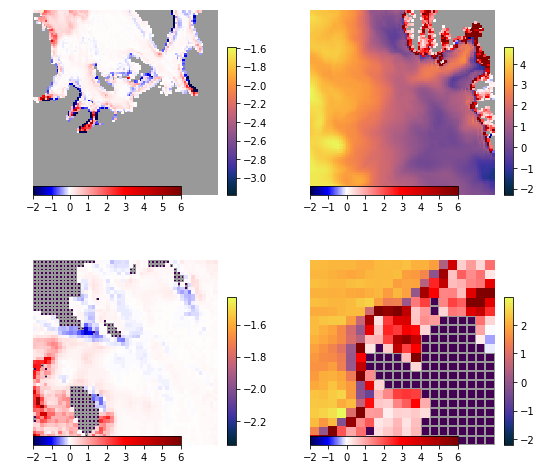

In [363]:
fig,axes = plt.subplots(2,2,figsize=(8.27,8.27))

for sel,ax in zip(slices,axes.flatten()):
    
    ax = make_plt(sel,ax)
    ax.set_aspect('equal')
    ax.axis('off')    
    
plt.subplots_adjust(hspace=0.25,
                    wspace=0.5)

In [278]:
plt.colorbar?

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import numpy as np
import cmocean.cm as ocm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data')
fig_dir = os.path.join(proj_dir,'reports','devel','figures')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from visualization.shiftedColorMap import shiftedColorMap
from tools.rotate_vector_roms import rotate_vector_roms
from tools.log_progress import log_progress
from tools.make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves
# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1
%aimport tools.rotate_vector_roms

In [2]:
from dask.distributed import Client
c = Client()
c

Client Scheduler: tcp://127.0.0.1:35008 Dashboard: http://127.0.0.1:43670/status,Cluster Workers: 16 Cores: 16 Memory: 101.38 GB


In [2]:
shelves_path = os.path.join(data_dir,'analysis','interim','shelves2_masks.npy')
shelves = np.load(shelves_path,allow_pickle=True).item()

grd_path = os.path.join(data_dir,'preprocessing','processed','waom2_grd.nc')
grd = xr.open_dataset(grd_path)

m_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_m_avg.nc')
m = xr.open_dataset(m_path).m.isel(ocean_time=0)

temp_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
temp = xr.open_dataset(temp_path).temp.isel(ocean_time=0)

In [3]:
mask_sector_path = os.path.join(data_dir,'analysis','interim','mask_sector2.npy')
mask_sector = np.load(mask_sector_path,allow_pickle=True).item()

In [4]:
grd.mask_rho[1000:1500,2000:2500] = False

mask_shelf = make_mask_shelf_sector(grd,mask_sector,1600) 
mask_shelf['Total Antarctica'][:,3000:]=False
mask_shelf['Total Antarctica'][2500:,:]=False

In [5]:
grd_dV_path = os.path.join(data_dir,'analysis','interim','grd2_dV.nc')
grd = xr.open_dataset(grd_dV_path)

In [6]:
def plot_ismr_temp_map(m,temp,grd,shelves,sectors,title,m_min=-1,m_max=6,t_min=-2,t_max=1,out_path=False):

    plt.tight_layout()
    #plt.rcParams.update({'font.size': 12})
    m_cmap = shiftedColorMap(plt.cm.seismic,midpoint = (1 - m_max/(m_max + abs(m_min))))
    s2a = 3600*24*365.25
   
    plt.close()
    fig,ax = plt.subplots(figsize=(10,14))
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))
    
    #ax.contourf(grd.mask_rho.where((grd.mask_rho==1) & (grd.zice<0)),colors=(('0.8','0.8','0.8')))
    #ax.contourf(grd.mask_rho.where((grd.mask_rho==1) & (grd.zice<0) & (grd.zice> -200)),colors=(('0.9','0.9','0.9')))
    #ax.contourf(grd.mask_rho.where((grd.mask_rho==1) & (grd.zice<0) & (grd.zice> -400)),colors=(('0.9','0.9','0.9')))
    temp_plt = ax.pcolormesh(temp,vmin=t_min,vmax=t_max,cmap=ocm.thermal)
    m_plt = ax.pcolormesh(m.where((grd.mask_rho ==1) & (grd.zice<0.0))*s2a,vmin=m_min,vmax=m_max,cmap=m_cmap)
    
    ax.contour(grd.zice.where(grd.mask_rho==1), levels=['-0.1'], colors=('black'),linewidths=0.1)
    ax.contour(grd.h.where(mask_shelf['Total Antarctica']), levels=['500','1000','1500'], colors=('black'),
               linewidths=0.2)
    ax.contour(grd.mask_rho, colors=('black'),linewidths=0.1)
    
    cb1 = plt.colorbar(temp_plt, ax=ax, orientation="horizontal", pad=0.01, extend='both')
    cb1.set_label(label='Potential temperature in $^{\circ}$C', size='xx-large', weight='bold')
    cb1.ax.tick_params(labelsize='xx-large')  
    
    cb2 = plt.colorbar(m_plt, ax=ax, orientation="horizontal", pad=0.1, extend='both')
    cb2.set_label(label='Melt rate in m/yr', size='xx-large', weight='bold')
    cb2.ax.tick_params(labelsize='xx-large')    
    
    #ax.contour((grd.zice >= -400) & (grd.mask_rho ==1), levels=['0.05'], colors=('black'),linewidths=0.2)
    #ax.contour((grd.zice >= -200) & (grd.mask_rho ==1), levels=['0.05'], colors=('black'),linewidths=0.2,linestyles='dashed')
    
    #names = ['Ronne','Filchner']
    #test = { key:value for key,value in shelves.items() if key in names}

    #for key,data in log_progress(shelves.items(),name='shelves'):
    #       ax.contour(data['mask'], colors=('black'),linewidths=0.05)
            
    #cbaxes1 = fig.add_axes([0.12, 0.2, 0.45, 0.02])
    #cbaxes2 = fig.add_axes([0.62, 0.2, 0.45, 0.02])
       
    #plt.colorbar(m_plt,cax=cbaxes1,extend='both',label='Melt rate [m/yr]',orientation="horizontal")
    #plt.colorbar(temp_plt,cax=cbaxes2,extend='both',label='Potential temperature [degC]',orientation="horizontal")
    
    #for k,sec_mask in mask_sector.items():
    #    sec_mask.where((grd.mask_rho ==1)&(grd.zice==0.0)).plot.contour(colors=('black'),linewidths=0.1,ax=ax) 
    
    ax.set_aspect('equal')
    ax.axis('off')

    
    if out_path:
        plt.savefig(out_path,format='png',dpi=400,bbox_inches = "tight")
    plt.show()

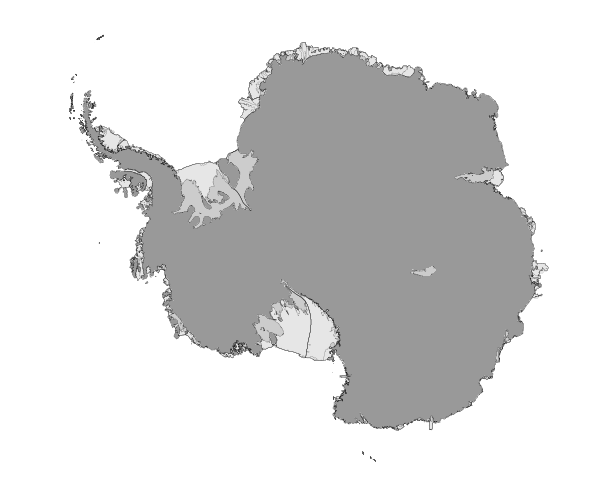

In [55]:
%matplotlib inline
plot_ismr_temp_map(m,temp.isel(s_rho=30),grd,shelves,mask_sector,
                   'Ice shelf basal melting (m/yr) and surface layer\n potential temperatures (degC), annual maximum',
                   m_min=-2,m_max=4,t_min=-2,t_max=2,
                   #out_path=os.path.join(proj_dir,'reports','figures','ismr_surface_temps.png'
                   out_path=os.path.join(proj_dir,'reports','figures','shallow_masks.png')
                  )

In [29]:
plt.savefig(out_path,format='png',dpi=400)

<Figure size 432x288 with 0 Axes>

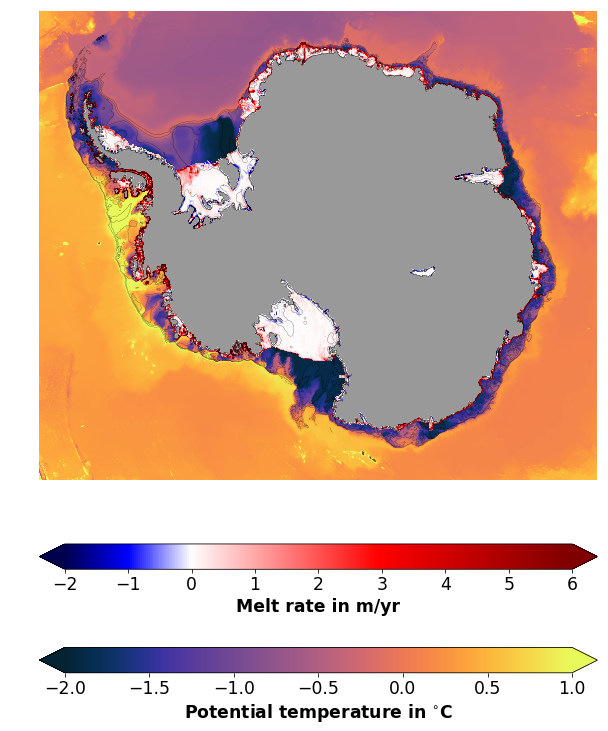

In [7]:
%matplotlib inline
plot_ismr_temp_map(m,temp.isel(s_rho=0),grd,shelves,mask_sector,
                   'Ice shelf basal melting (m/yr) and deep water potential temperatures (degC)\n, annual averages',
                   m_min=-2,m_max=6,
                   t_min=-2,t_max=1.0,
                   out_path=os.path.join(fig_dir,'ismr_bottom_temps_warm.png'))

In [ ]:
plot_ismr_temp_map(m,temp.isel(s_rho=0),grd,shelves,mask_sector,
                   'Ice shelf basal melting (m/yr) and deep water potential temperatures (degC)\n, annual averages',
                   m_min=-2,m_max=6,
                   t_min=-2,t_max=1.0,
                   out_path=os.path.join(fig_dir,'ismr_bottom_temps_warm.png'))

In [25]:
out_path = os.path.join(proj_dir,'reports','figures','ismr_botoms_temps.png')
plt.savefig(out_path,format='png',dpi=200)

<Figure size 432x288 with 0 Axes>

In [171]:
ubar_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_ubar_avg.nc')
ubar = xr.open_dataset(ubar_path).ubar.isel(ocean_time=0)
vbar_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_vbar_avg.nc')
vbar = xr.open_dataset(vbar_path).vbar.isel(ocean_time=0)

In [271]:
angle = np.zeros_like(grd.lon_rho.values)
u_rho,v_rho = rotate_vector_roms(ubar.values, vbar.values, angle)
u_rho = xr.DataArray(u_rho,dims=('eta_rho','xi_rho'))
v_rho = xr.DataArray(v_rho,dims=('eta_rho','xi_rho'))

In [330]:
def plot_ismr_temp_uv_map(m,temp,u_rho,v_rho,grd,shelves,mask_sector,title,m_min=-2,m_max=4,t_min=-2,t_max=1,uv_max=0.02,bl=5,out_path=False):
    
    m_cmap = shiftedColorMap(plt.cm.seismic,midpoint= (1 - m_max/(m_max + abs(m_min))))

    s2a = 3600*24*365.25
    mask = (grd.zice < 0.0)&(grd.mask_rho==1)
    land_zice = (grd.mask_rho==0) | (grd.zice < 0.0)
    
    #angle = np.zeros_like(grd.lon_rho.values)
    #u_rho,v_rho = rotate_vector_roms(u.values, v.values, angle)
    u_rho = u_rho.values
    v_rho = v_rho.values
    oo = (grd.mask_rho == 0) | (np.sqrt(np.square(u_rho) + np.square(v_rho)) < uv_max)
    u_rho[oo]=np.nan
    v_rho[oo]=np.nan
    
    fig,ax = plt.subplots()
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))
    temp_plt = ax.pcolormesh(temp,vmin=t_min,vmax=t_max,cmap=ocm.thermal)
    m_plt = ax.pcolormesh(m.where((grd.mask_rho ==1) & (grd.zice<0.0))*s2a,vmin=m_min,vmax=m_max,cmap=m_cmap)
    
    #names = ['Ronne','Filchner']
    #shelves_test = { key:value for key,value in shelves.items() if key in names}

    for key,data in log_progress(shelves.items(),name='shelves'):
        mask = xr.DataArray(data['mask'],dims=('eta_rho','xi_rho'))
        ax.contour(mask.loc[sel_rho], colors=('black'),linewidths=0.5)
            
    #cbaxes1 = fig.add_axes([0.12, 0.15, 0.45, 0.02])
    #cbaxes2 = fig.add_axes([0.62, 0.15, 0.45, 0.02])
       
    #plt.colorbar(m_plt,cax=cbaxes1,extend='both',label='Melt rate [m/yr]',orientation="horizontal")
    #plt.colorbar(temp_plt,cax=cbaxes2,extend='both',label='Potential temperature [degC]',orientation="horizontal")
    
    #for k,sec_mask in mask_sector.items():
    #    sec_mask.where((grd.mask_rho ==1)&(grd.zice==0.0)).plot.contour(colors=('black'),linewidths=0.1,ax=ax) 
    
    ax.set_aspect('equal')
    ax.axis('off')
    
    i=grd.xi_rho.size
    j=grd.eta_rho.size
    
    quiverp = ax.quiver(np.arange(1,i,bl),np.arange(1,j,bl),
                        u_rho[1:j:bl,1:i:bl],
                        v_rho[1:j:bl,1:i:bl],color='black')
    
    #ax.quiverkey(quiverp, 0.90, 0.02, 0.1, r'$10 \frac{cm}{s}$', labelpos='E',coordinates='axes')
    
    if out_path:
        plt.savefig(out_path,format='png',dpi=400,bbox_inches = "tight")
    plt.show()

In [239]:
ax.quiverkey?

In [312]:
xmin,xmax=(1200,1750)
ymin,ymax=(600,1200)
sel_rho={'xi_rho':slice(xmin,xmax),'eta_rho':slice(ymin,ymax)}
sel_u={'xi_u':slice(xmin,xmax),'eta_u':slice(ymin,ymax)}
sel_v={'xi_v':slice(xmin,xmax),'eta_v':slice(ymin,ymax)}

In [ ]:
xmin,xmax=(1200,1700)
ymin,ymax=(650,1150)

In [327]:
xmin,xmax=(400,750)
ymin,ymax=(1100,1775)

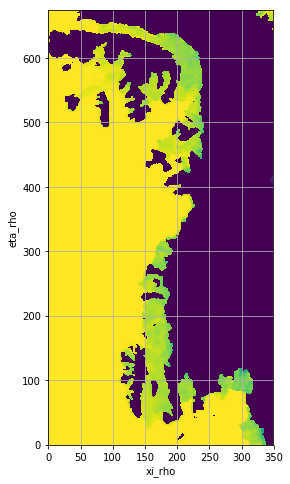

In [328]:
%matplotlib inline
sel_rho={'xi_rho':slice(xmin,xmax),'eta_rho':slice(ymin,ymax)}
plt.close()
fig,ax = plt.subplots(figsize=(8,8))
grd.mask_rho.loc[sel_rho].plot(add_colorbar=False,ax=ax)
grd.zice.where((grd.mask_rho == 1) & (grd.zice < 0.0)).loc[sel_rho].plot(ax=ax,add_colorbar=False)
ax.grid()
ax.set_aspect('equal')
plt.show()

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


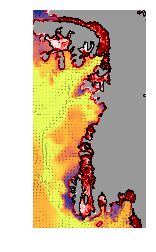

In [331]:
%matplotlib inline
plot_ismr_temp_uv_map(m.loc[sel_rho],temp.isel(s_rho=0).loc[sel_rho],u_rho.loc[sel_rho],v_rho.loc[sel_rho],grd.loc[sel_rho],shelves,mask_sector,
                   'Ice shelf basal melting (m/yr) and deep water potential temperatures (degC)\n, annual averages',
                   m_min=-2,m_max=4,t_min=-2,t_max=1.0,uv_max=0.003,
                   out_path=os.path.join(proj_dir,'reports','figures','tmp','ismr_btemps_uv_Go.png'),
                   bl=10)

In [107]:
def plot_temp_uv_map(temp,u,v,grd,title,t_min=-2,t_max=1,uv_max=0.02,bl=5,out_path=False):


    mask = (grd.zice < 0.0)&(grd.mask_rho==1)
    land = (grd.mask_rho==0)
    
    angle = np.zeros_like(grd.lon_rho.values)
    u_rho,v_rho = rotate_vector_roms(u.values, v.values, angle)
    oo = (grd.mask_rho == 0) | (np.sqrt(np.square(u_rho) + np.square(v_rho)) < uv_max)
    u_rho[oo]=np.nan
    v_rho[oo]=np.nan
    
    matplotlib.rcParams.update({'font.size': 18})
    
    plt.close()
    fig,ax = plt.subplots(figsize=(15,8))
    ax.contourf(grd.mask_rho.where(land).values,colors=(('0.6','0.6','0.6')))
    temp.where(~land).plot(vmin=t_min,vmax=t_max,ax=ax,cmap=ocm.thermal,cbar_kwargs={'label':''})
    ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5)
    ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
    
    quiverp = ax.quiver(np.arange(1,angle.shape[1],bl),np.arange(1,angle.shape[0],bl),
                        u_rho[1:angle.shape[0]:bl,1:angle.shape[1]:bl],
                        v_rho[1:angle.shape[0]:bl,1:angle.shape[1]:bl],color='black')
    ax.quiverkey(quiverp, 0.90, 0.97, 0.2, r'$20 \frac{cm}{s}$', labelpos='E',coordinates='axes')
    
    plt.title(title, fontsize=20)
    
    ax.set_aspect('equal')
    ax.axis('off')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path,format='png',dpi=375)
    plt.show()

In [101]:
def plot_ismr_map(m,grd,title,m_min=-1,m_max=6,out_path=False):

    m_cmap = shiftedColorMap(plt.cm.seismic,midpoint= (1 - m_max/(m_max + abs(m_min))))

    s2a = 3600*24*365.25
    mask = (grd.zice < 0.0)&(grd.mask_rho==1)
    land_zice = (grd.mask_rho==0) | (grd.zice < 0.0)
    matplotlib.rcParams.update({'font.size': 18})
    
    plt.close()
    fig,ax = plt.subplots(figsize=(15,8))
    ax.contourf(grd.mask_rho.where(land_zice).values,colors=(('0.6','0.6','0.6')))
    (m.where(mask)*s2a).plot(vmin=m_min,vmax=m_max,ax=ax,cmap=m_cmap,cbar_kwargs={'label':''})
    ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5)
    ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
    
    plt.title(title, fontsize=20)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path,format='png',dpi=375)
    plt.show()

In [4]:
grid_path = os.path.join(data_dir,'preprocessing','processed','waom2_grd.nc')
grd2 = xr.open_dataset(grid_path)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


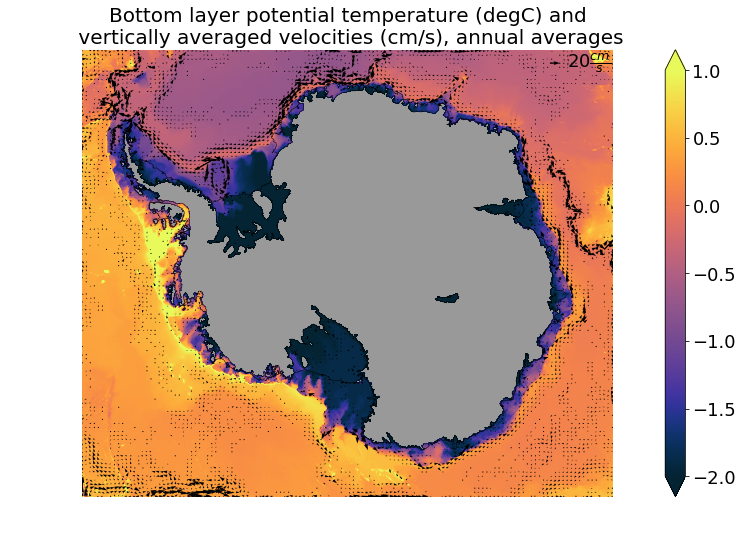

In [109]:
out_path = os.path.join(proj_dir,'reports','figures','uvTemp2.png')
file_path = os.path.join(data_dir,'analysis','raw','waom2_fix','bottom_temp.nc')
temp2 = xr.open_dataset(file_path)

file_path = os.path.join(data_dir,'analysis','raw','waom2_fix','ubar.nc')
ubar2 = xr.open_dataset(file_path)

file_path = os.path.join(data_dir,'analysis','raw','waom2_fix','vbar.nc')
vbar2 = xr.open_dataset(file_path)

plot_temp_uv_map(temp2.temp,
                ubar2.ubar.squeeze(),vbar2.vbar.squeeze(),
                grd2,'Bottom layer potential temperature (degC) and\n vertically averaged velocities (cm/s), annual averages',
                out_path=out_path,
                bl=24)

In [1]:
out_path = os.path.join(proj_dir,'reports','figures','ismr2.png')
file_path = os.path.join(data_dir,'analysis','raw','waom2_fix','m.nc')

m2 = xr.open_dataset(file_path)
plot_ismr_map(m2.m,grd2,
              'Ice shelf basal melt rates (m/yr), annual averages',
              #m_min=-2,m_max=2,
              #out_path = out_path)
             )

NameError: name 'os' is not defined

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


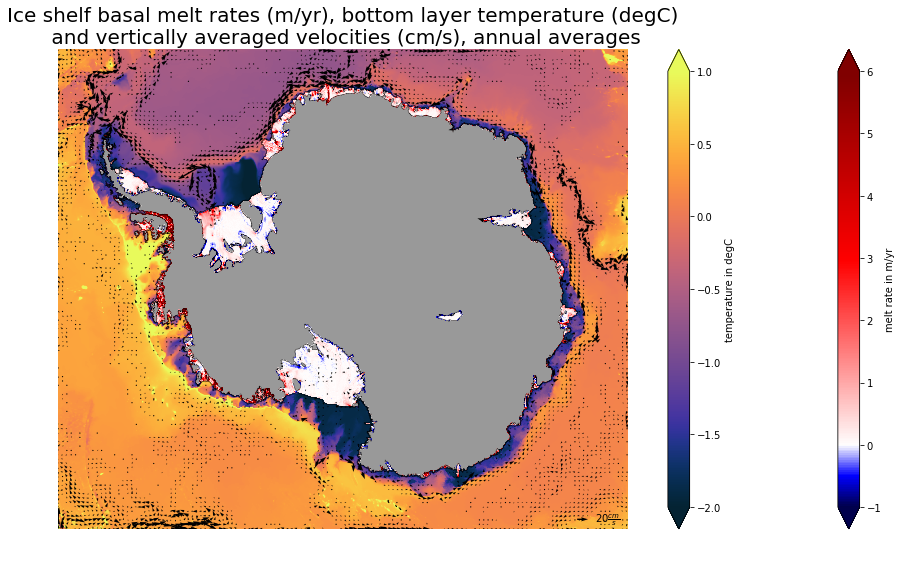

In [75]:
out_path = os.path.join(proj_dir,'reports','figures','ismrUvTemp2_hr.png')

file_path = os.path.join(data_dir,'analysis','raw','waom2_fix','m.nc')
m2 = xr.open_dataset(file_path)

file_path = os.path.join(data_dir,'analysis','raw','waom2_fix','bottom_temp.nc')
temp2 = xr.open_dataset(file_path)

file_path = os.path.join(data_dir,'analysis','raw','waom2_fix','ubar.nc')
ubar2 = xr.open_dataset(file_path)

file_path = os.path.join(data_dir,'analysis','raw','waom2_fix','vbar.nc')
vbar2 = xr.open_dataset(file_path)

plot_ismr_temp_uv_map(m2.m,temp2.temp,ubar2.ubar.squeeze(),vbar2.vbar.squeeze(),
                grd2,'Ice shelf basal melt rates (m/yr), bottom layer temperature (degC)\n and vertically averaged velocities (cm/s), annual averages',
                out_path=out_path,
                bl=24)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.d

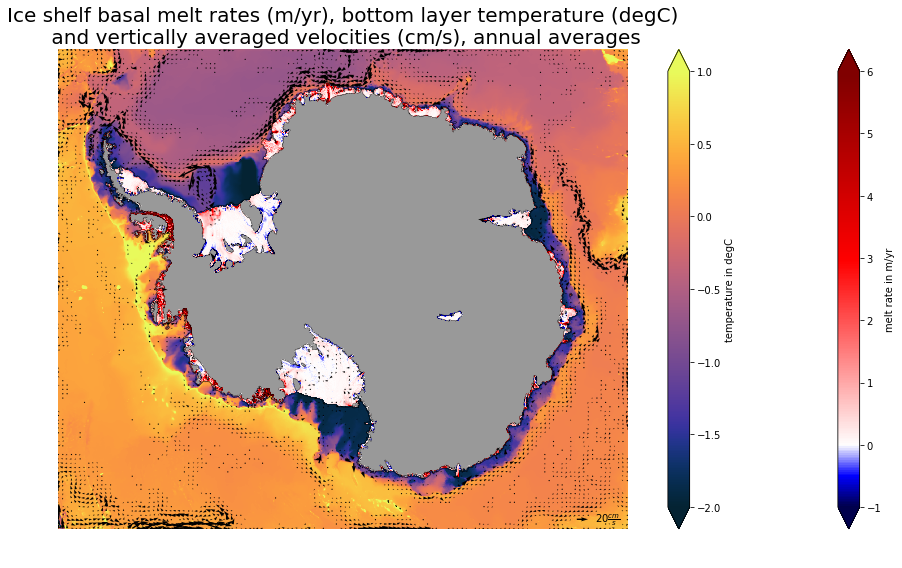

In [38]:
%matplotlib inline

out_path = os.path.join(proj_dir,'reports','figures','ismr4.png')
plot_ismr_temp_uv_map(avg4.m.mean('ocean_time'),avg4.temp.mean('ocean_time')[0],
                      avg4.ubar.mean('ocean_time'),avg4.vbar.mean('ocean_time'),
                      grd4,'Ice shelf basal melt rates (m/yr), bottom layer temperature (degC)\n and vertically averaged velocities (cm/s), annual averages',
                      bl=12,m_min
                      out_path = out_path)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.d

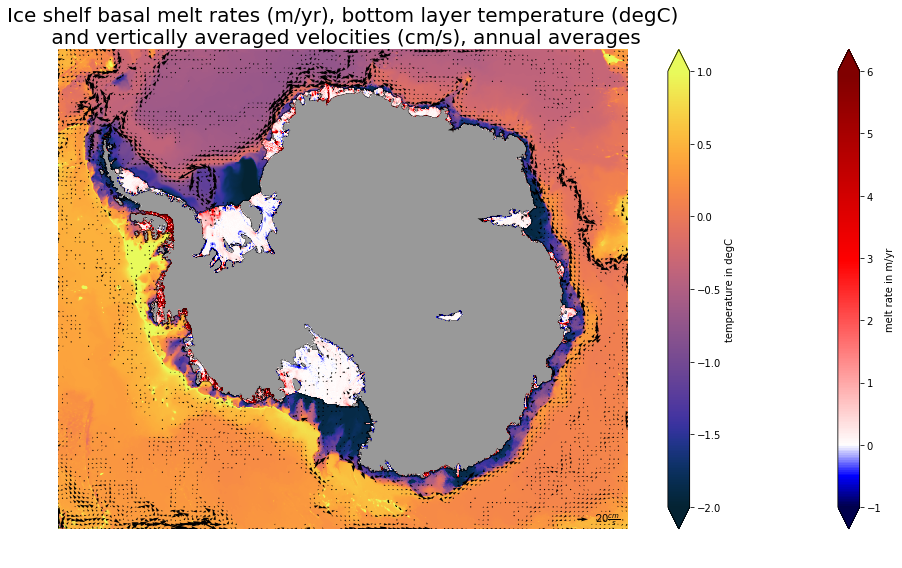

In [3]:
grid_path = os.path.join(data_dir,'preprocessing','processed','waom2_grd.nc')
file_path = os.path.join(data_dir,'analysis','raw','waom2_fix','ocean_avg_05??.nc')
out_path = os.path.join(proj_dir,'reports','figures','ismr2.png')
grd2 = xr.open_dataset(grid_path)
avg2 = xr.open_mfdataset(file_path,chunks={'eta_rho':100,'xi_rho':100})

out_path = os.path.join(proj_dir,'reports','figures','ismr2.png')
plot_ismr_temp_uv_map(avg2.m.mean('ocean_time'),avg2.temp.mean('ocean_time')[0],
                      avg2.ubar.mean('ocean_time'),avg2.vbar.mean('ocean_time'),
                      grd2,'Ice shelf basal melt rates (m/yr), bottom layer temperature (degC)\n and vertically averaged velocities (cm/s), annual averages',
                      bl=24)

In [7]:
%matplotlib notebook
grid_path = os.path.join(data_dir,'preprocessing','processed','waom10_grd.nc')
file_path = os.path.join(data_dir,'analysis','raw','waom10_M3','ocean_avg_0009.nc')
grd10 = xr.open_dataset(grid_path)
avg10 = xr.open_mfdataset(file_path,chunks={'eta_rho':100,'xi_rho':100})
#avg10 = xr.open_dataset(file_path)
#plot_ismr_temp_map(avg10.m.mean('ocean_time'),avg10.temp.mean('ocean_time')[0],grd10,'test',-1,6,-2,1)

In [15]:
grid_path = os.path.join(data_dir,'preprocessing','processed','waom4_grd.nc')
file_path = os.path.join(data_dir,'analysis','raw','waom4','ocean_avg_0009.nc')
grd4 = xr.open_dataset(grid_path)
avg4 = xr.open_mfdataset(file_path,chunks={'eta_rho':100,'xi_rho':100})
#avg4 = xr.open_dataset(file_path)

%matplotlib inline
#plot_ismr_temp_map(avg4.m.mean('ocean_time'),avg4.temp.mean('ocean_time')[0],grd4,'test',-1,6,-2,1)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.d

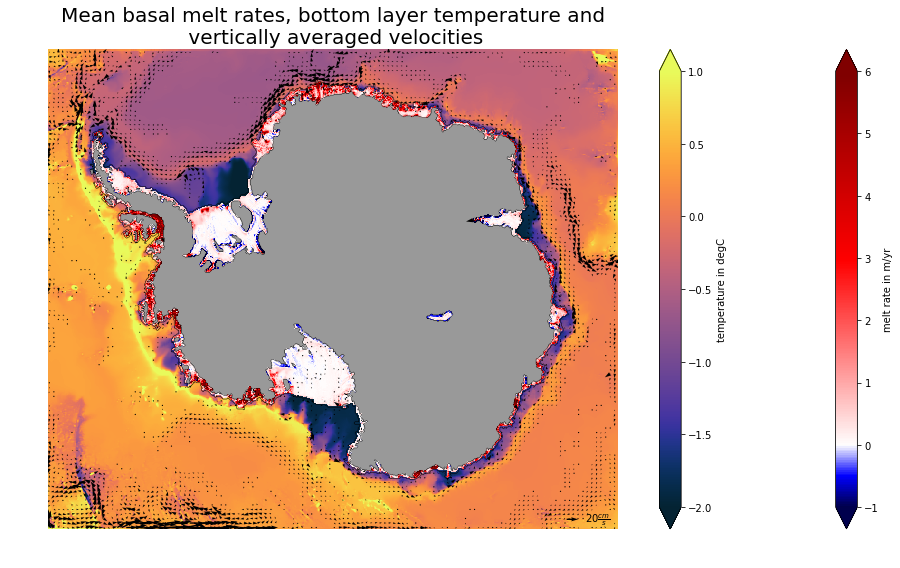

In [20]:
%matplotlib inline
out_path = os.path.join(proj_dir,'reports','figures','ismr10.png')
plot_ismr_temp_uv_map(avg10.m.mean('ocean_time'),avg10.temp.mean('ocean_time')[0],
                      avg10.ubar.mean('ocean_time'),avg10.vbar.mean('ocean_time'),
                      grd10,'Mean basal melt rates, bottom layer temperature and\n vertically averaged velocities',
                     out_path=out_path)

In [42]:
%matplotlib inline
import xarray
datapath = "http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-0/amip/mon/atmos/Amon/r1i1p1/latest/tas/tas_Amon_ACCESS1-0_amip_r1i1p1_197901-200812.nc"
data = xarray.open_dataset(datapath)
surface_temp_slice = data.tas.sel(time = '1984-03').squeeze()
surface_temp_slice

<xarray.DataArray 'tas' (lat: 145, lon: 192)>
array([[222.76569, 222.76569, 222.76569, ..., 222.76569, 222.76569, 222.76569],
       [226.92981, 226.86505, 226.79605, ..., 227.14102, 227.07712, 227.00539],
       [228.85902, 228.67213, 228.48105, ..., 229.36661, 229.21709, 229.04408],
       ...,
       [245.73398, 245.6626 , 245.5486 , ..., 245.61552, 245.72032, 245.75853],
       [242.84557, 242.82965, 242.80466, ..., 242.87907, 242.8684 , 242.85567],
       [240.14352, 240.14352, 240.14352, ..., 240.14352, 240.14352, 240.14352]],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 1984-03-16T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 -85.0 -83.75 -82.5 ...
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.12 15.0 ...
    height   float64 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    cell_methods:      time: mean
    cell_measures:     area: areacell

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


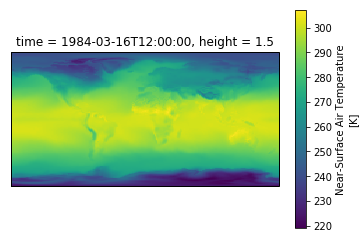

In [43]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.PlateCarree())

surface_temp_slice.plot(ax=ax)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


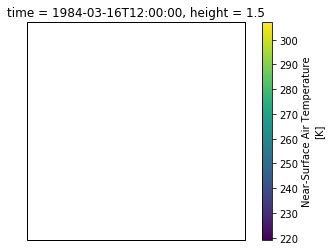

In [44]:
ax = plt.axes(projection=ccrs.LambertConformal())

surface_temp_slice.plot(ax=ax, transform=ccrs.PlateCarree())

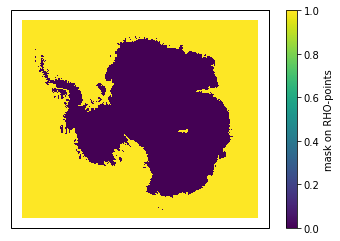

In [39]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

#ax = plt.axes(projection=ccrs.NearsidePerspective(central_latitude=-80, central_longitude=0))
ax = plt.axes(projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))


grd10.mask_rho.plot(ax=ax)
ax.coastlines()
#ax.set_extent([-40,40,-90,-50])

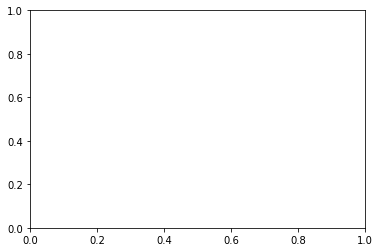